# Nonlinear diskoseismology: G-mode self-interaction

We first import the necessary modules:

In [1]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
from scipy import optimize

from disko import functions as func
from disko import base as dsk
from disko import figs
from disko import paczwiit as pw

from matplotlib import rc
rc('text', usetex=True)
rc('legend', frameon=False)

import matplotlib.pyplot as plt


Latex macros:
$$
    \newcommand{\cs}{c_\mathrm{s}}
    \newcommand{\U}{\mathcal{U}}
    \newcommand{\W}{\mathcal{W}}
    \newcommand{\bg}{{\bar{\mathrm{g}}}}
    \newcommand{\g}{{\mathcal{g}}}
$$

Introduce an isothermal accretion disk with sound speed $\cs=0.005c$ in Paczynski-Wiita potential. By default, the outer disk radius is at $r=100M$. The inner edge is at `disk.rin` that coincides with ISCO. The maximum of the radial epicyclic frequency is at `rmax` that is calculated using `disk.r_kappa_max()`:

In [125]:
mycolor = '#9467bd'
myrecolor = '#1f77b4'

In [126]:
disk = pw.Disk(cs = 0.01)
rmax = disk.r_kappa_max()

print('rin  = ', disk.rin)
print('rmax = ', rmax)

rin  =  6.0000000001
rmax =  7.464101615137754


## Propagation diagram of the modes

Draw the propagation diagram for the axisymmetric modes: 

In [127]:
def plot_component(panels, mode, W, radii, rlab=None, bckg=None, freqlim=None):

    def make_ysym(ax):
        ymin, ymax = ax.get_ylim()
        y = max(abs(ymin), abs(ymax))
        ax.set_ylim(-y, y)
        
    
    mycolor = plt.rcParams['axes.prop_cycle'].by_key()['color'][4]
    myrecolor = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    myimcolor = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    if rlab == None: rlab = 0.5*(radii[0] + radii[-1])

    ax1, ax2, ax3 = panels
    
    if freqlim == None:
        ax1.set_ylim(0, 2.5*mode.disk.kappa(mode.disk.r_kappa_max()).real)
    else:
        ax1.set_ylim(*freqlim)
        
    figs.propagation_diagram(ax1, mode, radii, rlab=rlab, plot_grid=True, mcolor=mycolor)
    figs.eigenfunction_plot([ax2, ax3], mode, W, radii, components=[0,1], 
                            norm=[1/disk.cs**2, 1/disk.cs], reslabels=False, 
                            recolor=myrecolor, imcolor=mycolor, ylabels=[r'$h/c_\mathrm{s}^2$', r'$v^r/c_\mathrm{s}$'])
    if bckg != None:
        mode_bckg, rlab_bckg = bckg
        figs.propagation_diagram(ax1, mode_bckg, radii, rlab=rlab_bckg, plot_grid=False, mcolor='gray', ccolor='gray')

    ax1.set_xticks([])
    ax1.set_xticklabels([])
    ax1.set_xlabel('')
    ax1.annotate(r'$n={}$'.format(mode.n), xy=(0.99, 0.95), xycoords='axes fraction', va='top', ha='right') 

    ax2.set_xticks([])
    ax3.legend(loc='lower right')
    make_ysym(ax2)
    make_ysym(ax3)
    #return fig;
    
def plot_components(modes, Ws, radii, rlabs=None, bckg=None, freqlim=None):
    
    ncomps = len(modes)
    fig = plt.figure(constrained_layout=True, figsize=(ncomps*5,6))
    spec = fig.add_gridspec(ncols=ncomps, nrows=3, height_ratios=[1.5,1,1])
    
    for i, (mode, W) in enumerate(zip(modes, Ws)):
        panels = [fig.add_subplot(spec[j, i]) for j in range(3)]
        if rlabs == None:
            rlab = None
        else:
            rlab = rlabs[i]
        plot_component(panels, mode, W, radii, rlab=rlab, bckg=bckg, freqlim=freqlim)
        
    fig.align_ylabels()
    fig.align_xlabels()
    
    
    

Propagation diagram of axisymmetric modes:

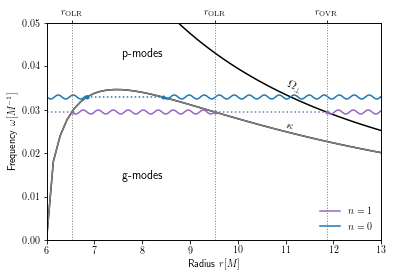

In [128]:
# example modes (not real)
def example_propagation_diagram():

    gmode = dsk.ModeParam(disk, omega=0.85*disk.kappa(rmax), m=0, n=1)
    pmode = dsk.ModeParam(disk, omega=0.95*disk.kappa(rmax), m=0, n=0)
    radii = np.linspace(disk.rin, 13)

    fig, ax = plt.subplots(1)
    ax.set_ylim(0, 1.7*gmode.omega.real)
    figs.propagation_diagram(ax, gmode, radii, rlab=11, plot_grid=True, mcolor=mycolor)
    figs.propagation_diagram(ax, pmode, radii, rlab=11, plot_grid=False, mcolor=myrecolor, ccolor='gray')
    ax.annotate('g-modes', xy=(8, 0.5*gmode.omega.real), va='center', ha='center', fontsize='large')
    ax.annotate('p-modes', xy=(8, 1.45*gmode.omega.real), va='center', ha='center', fontsize='large')

    # ...to have a legend:
    ax.plot([gmode.LRs[1]], [gmode.omega.real], color=mycolor, label=r'$n=1$')
    ax.plot([pmode.LRs[1]], [pmode.omega.real], color=myrecolor, label=r'$n=0$')
    ax.legend(loc='lower right')

    plt.savefig('propagation-m0.pdf', bbox_inches='tight')


example_propagation_diagram()    

## Linear g-modes ##

We introduce `ModeParam` class that describes our first estimate of the parameters of the axisymmetric mode near the top of the radial epicyclic frequency $\kappa$. This mode has 3 resonances: inner and outer Lindblad resonance and the vertical resonance. Their radii are given by `LRs` and `VRs` methods of `ModeParam` class. There is no corotation resonance as can be seen by applying `CR` method:

In [129]:
trial_mode_g = dsk.ModeParam(disk, omega=0.95*disk.kappa(rmax), m=0, n=1)
rILR, rOLR = trial_mode_g.LRs
rVR = trial_mode_g.VRs[1]
print('rILR = ', rILR)
print('rOLR = ', rOLR)
print('rVR  = ', rVR)

rILR =  6.844354542885293
rOLR =  8.425503015382194
rVR  =  11.108249140363649


Now, the boundary conditions. At the inner disk edge, we introduce, the zero radial velocity boundary condition, $v^r|_{r_\mathrm{in}} = 0$. Behind the outer Lindblad resonance (say at $1.2 r_\mathrm{OLR}$), we introduce the out-going wave boundary condition to mimic a behavior of an infinite disk:

In [130]:
bc1 = dsk.bcZeroVelocity(disk, disk.rin)
bc2 = dsk.bcWave(disk, 1.2*rVR, which='outgoing')
radii = np.linspace(bc1.r, bc2.r) #np.concatenate((np.linspace(bc1.r, rmax-0.1), np.linspace(rmax+0.1, bc2.r)))
radii2 = np.linspace(bc1.r, bc2.r, 200)

With these boundary conditions we may call the function `find_mode` to return actual parameters of the g-mode. By supplying the parameter `radii`, we get also the sampled radial eigenfunction $W_\mathrm{g}$ at given points. The normalization of the eigenfunction is given by `norm` parameter. Our normalization is such that the maximal radial velocity perturbation is 20% of the sound speed $c_\mathrm{s}$. This eigenfunction can then be plotted using the function `figs.eigenfunction_plot`. We also introduce a complex-conjugated mode $W_\bar{\mathrm{g}}$ using the function `conjugate`: 

In [131]:
rm = rmax-1e-2
mode_g, W_g = dsk.find_mode(trial_mode_g, bc1, bc2, rmax, radii, norm={'vmax': disk.cs})
mode_G, W_G = dsk.conjugate(mode_g, W_g)
W_g.set_eval(('linear', 'linear'))
W_G.set_eval(('linear', 'linear'))
print('g-mode parameters:', mode_g)
print('G-mode parameters:', mode_G)
print('g-mode frequency in kappa_max:', mode_g.omega/disk.kappa(rmax))

g-mode parameters: ModeParam(omega=(0.033421471865577854-8.134756763553739e-07j), m=0, n=1)
G-mode parameters: ModeParam(omega=(-0.033421471865577854-8.134756763553739e-07j), m=0, n=1)
g-mode frequency in kappa_max: (0.9638443030084074-2.3459885293040543e-05j)


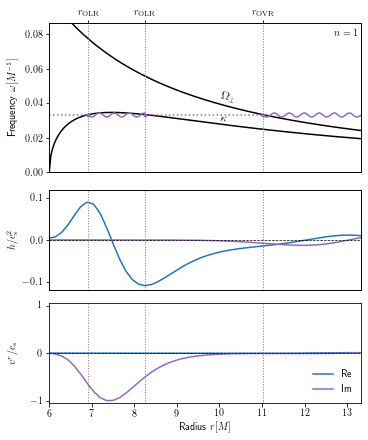

In [132]:
plot_components([mode_g], [W_g], radii2, rlabs=[10])
#plt.savefig('g-mode.pdf', bbox_inches='tight')

... it is not strict complex conjugation as the imaginary part is also negative (this mode is also damped). Instead we have $(i\omega_\mathrm{g})^\ast = i\omega_\bar{\mathrm{g}}$. Our governing equations support that (CHECK)

In the linear order, we have a solution described by a  linear combination of $\W_\g$ and $\W_\bg$:
\begin{equation}
    W^{(1)}(T_0, T_1, T_2) = A(T_1, T_2) \W_\g(r,y) e^{-i\omega_\g T_0} + A^\ast(T_1, T_2)\W_\g(r,y) e^{-i\omega_\g T_0}
\end{equation}
Again, the two components are complex conjugated, eventhough $\omega_\g^\ast\neq\omega_\bg$. This follows from the requirement of reality of the solution. The solution can be also written as
\begin{equation}
    W^{(1)}(T_0, T_1, T_2) = \left[A(T_1, T_2) \W_\g e^{-i\mathrm{Re}(\omega_\g) T_0} + \mathrm{cc.}\right] e^{-\mathrm{Im}(\omega_\g) T_0}.
\end{equation}

## Quadratic coupling ##

In the second order, we have to calculate forcing term $Q_{11}\equiv Q(\W^{(1)}, \W^{(1)})$ on the right-hand side of the second order equations. By substituting the first-order solution we have,
\begin{align}
    Q(W^{(1)}, W^{(1)}) &= A^2 Q(\W_\g, \W_\g) e^{-2i\omega_\g T_0} + 2|A|^2 Q(\W_\g, \W_\bg) e^{-2\mathrm{Im}(\omega_\g) T_0} + 
                            A^{\ast 2} Q(\W_\g, \W_\bg) e^{-2i\omega_\bg T_0} 
    \nonumber \\  
                        &\equiv A^2 Q_{\g\g} e^{-2i\omega_\g T_0} + 2|A|^2 Q_{\g\bg} e^{-2\mathrm{Im}(\omega_\g) T_0} +
                                A^{\ast 2} Q_{\bg\bg} e^{-2i\omega_\bg T_0}    
\end{align}
In addition, there is also a term
\begin{equation}
    -\frac{\partial W^{(1)}}{\partial T_1} = -\frac{\partial A}{\partial T_1} \W_\g(r,y) e^{-i\omega_\g T_0} 
                                             -\frac{\partial A^\ast}{\partial T_1} \W_\bg(r,y) e^{-i\omega_\g T_0}
\end{equation}
arising from the multiple scale expansion.

First of all, the only terms that depend on time as $\exp(-i\omega_\g T_0)$, or $\exp(-i\omega_\bg T_0)$ are those comming from multiple time-scale expansion. Since $\langle \U_\g | \W_\g\rangle$ = $\langle \U_\bg | \W_\bg\rangle^\ast \neq 0$. The appropriate solvability condition is
\begin{equation}
    \frac{\partial A}{\partial T_1} = 0,
\end{equation}
therefore $A = A(T_2)$. Next, we should check also other forcing terms arising from the coupling. It is clear that there are no modes (solutions of the linear problem with our boundary conditions) with appropriate freqeuncies. So, our method is consistent. In case such modes exist, it would be necessary to introduce them already in the linear order.


In calculations of $Q_{\g\g}$, $Q_{\g\bg}$ and $Q_{\bg\bg}$, we use `nonlinear_coupling` function. Note that the forcing terms may have different components in vertical nodal numbers $n$.

We start with $Q_{\g\g}$ components. As can be seen, there are two forcing terms corresponding to $n=0$ and $n=2$:

### Nonlinear forces

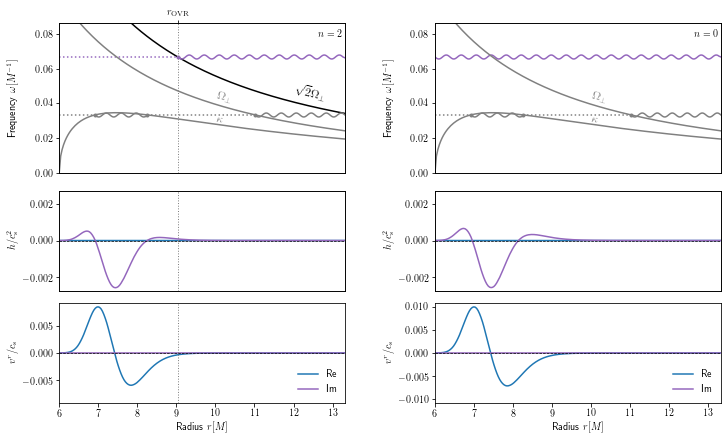

In [133]:
modes_gg, forces_gg = dsk.nonlinear_coupling(mode_g, W_g, mode_g, W_g)
plot_components(modes_gg, forces_gg, radii2, rlabs=[12, 12], bckg=(mode_g, 10))


And in the case of the $F_{\mathrm{g}\bar{\mathrm{g}}}$ component the situation is simmilar:

/home/jiri/Documents/notes/2020-g-modes/disko/base.py:326: RuntimeWarning: divide by zero encountered in cdouble_scalars
  return (omegat**2 - kappa**2)*(omegat**2 - self._n*Omegav**2)/(omegat*self._disk.cs)**2
/home/jiri/Documents/notes/2020-g-modes/disko/base.py:326: RuntimeWarning: invalid value encountered in cdouble_scalars
  return (omegat**2 - kappa**2)*(omegat**2 - self._n*Omegav**2)/(omegat*self._disk.cs)**2
/home/jiri/Documents/notes/2020-g-modes/disko/base.py:326: RuntimeWarning: invalid value encountered in cdouble_scalars
  return (omegat**2 - kappa**2)*(omegat**2 - self._n*Omegav**2)/(omegat*self._disk.cs)**2


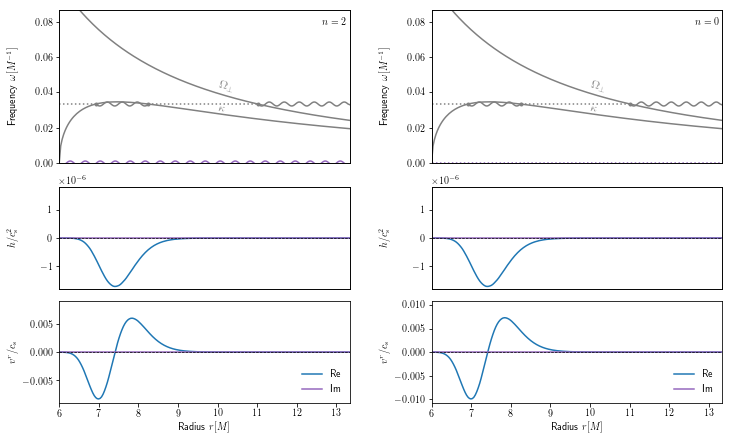

In [134]:
modes_gG, forces_gG = dsk.nonlinear_coupling(mode_g, W_g, mode_G, W_G)
plot_components(modes_gG, forces_gG, radii2, rlabs=[12, 12], bckg=(mode_g, 10))
for F in forces_gG:
    F.set_eval(('linear', 'linear'))

The azimuthal forxe is does not vanish at large distances (WKBJ region). Note that in the case of $n=2$ mode $F^\phi\propto ikv^rv^{\phi\ast}\propto k(r)$

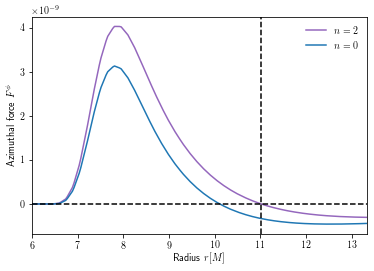

In [135]:
def plot_azimuthal_force():
    fig, ax = plt.subplots(1, figsize=(6,4))
    ax.plot(radii2, [forces_gG[0](r)[2].real for r in radii2], color=mycolor, label=r'$n={}$'.format(modes_gG[0].n))
    ax.plot(radii2, [forces_gG[1](r)[2].real for r in radii2], color=myrecolor, label=r'$n={}$'.format(modes_gG[1].n))
    ax.axhline(0, ls='--', color='black')
    ax.axvline(mode_g.VRs[1], ls='--', color='black' )
    ax.set_xlabel(r'Radius $r[M]$')
    ax.set_ylabel(r'Azimuthal force $F^\phi$')
    ax.set_xlim(radii2[0], radii2[-1])
    ax.legend()

plot_azimuthal_force()

In [136]:
modes_GG, forces_GG = dsk.nonlinear_coupling(mode_G, W_G, mode_G, W_G)

We will now try to find responses to these forcings:

Resonances: [[], []]


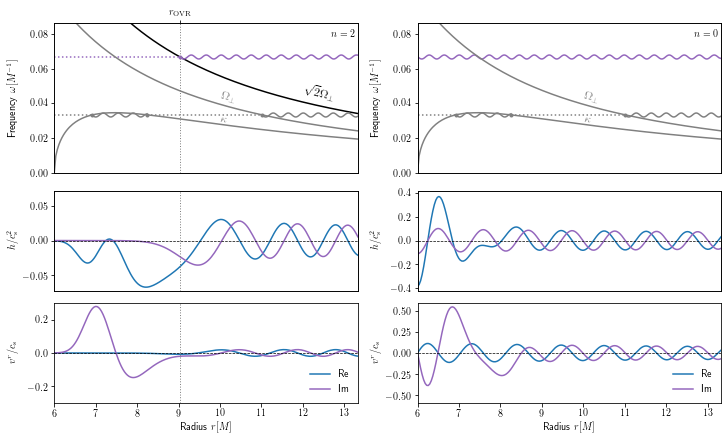

In [137]:
Ws_gg = []
for mode, force in zip(modes_gg, forces_gg):
    Ws_gg.append(dsk.find_response(mode, force, bc1, bc2, rm, radii))

print('Resonances:', [dsk.radial_resonances(mode_g, mode_g, mode) for mode in modes_gg])
    
plot_components(modes_gg, Ws_gg, radii2, rlabs=[12, 12], bckg=(mode_g, 10))
plt.savefig('gg-response.pdf', bbox_inches='tight')

...we see quite strong outgoing waves (both in g-mode and p-mode) from the original g-mode trapping region.

Enetering response00()
response00: order 0
Enetering response00()
response00: order 0
Resonances: [[], []]


/home/jiri/Documents/notes/2020-g-modes/disko/base.py:326: RuntimeWarning: divide by zero encountered in cdouble_scalars
  return (omegat**2 - kappa**2)*(omegat**2 - self._n*Omegav**2)/(omegat*self._disk.cs)**2
/home/jiri/Documents/notes/2020-g-modes/disko/base.py:326: RuntimeWarning: invalid value encountered in cdouble_scalars
  return (omegat**2 - kappa**2)*(omegat**2 - self._n*Omegav**2)/(omegat*self._disk.cs)**2
/home/jiri/Documents/notes/2020-g-modes/disko/base.py:326: RuntimeWarning: invalid value encountered in cdouble_scalars
  return (omegat**2 - kappa**2)*(omegat**2 - self._n*Omegav**2)/(omegat*self._disk.cs)**2


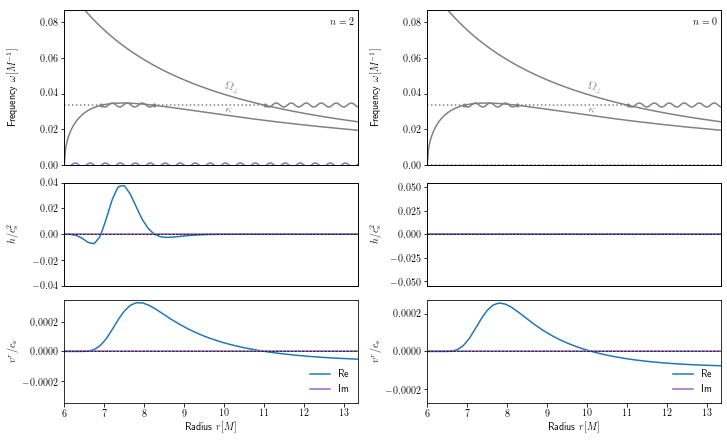

In [138]:
Ws_gG = []
for mode, force in zip(modes_gG, forces_gG):
    W = dsk.find_response(mode, force, bc1, bc2, 7, radii, order00=0)
    W.set_eval(('linear', 'linear'))
    Ws_gG.append(W)

print('Resonances:', [dsk.radial_resonances(mode_g, mode_G, mode) for mode in modes_gG])

plot_components(modes_gG, Ws_gG, radii2, rlabs=[12, 12], bckg=(mode_g, 10))
plt.savefig('gG-response.pdf', bbox_inches='tight')


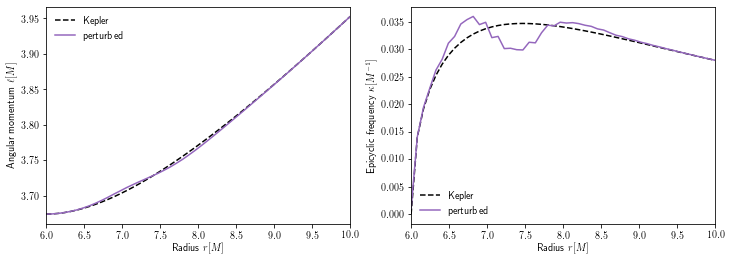

In [139]:
def new_angular_momentum():
   
    lKep = func.IntervalFunction(lambda r: r**2*disk.Omega(r), bc1.r, bc2.r)
    lpert = func.IntervalFunction(lambda r: r**2*(disk.Omega(r) + Ws_gG[0](r)[2].real), bc1.r, bc2.r)
    kappa_pert = func.IntervalFunction(lambda r: math.sqrt(2*(disk.Omega(r) + Ws_gG[0](r)[2].real)/r * lpert.der(r)), bc1.r, bc2.r)
    
    
    
    rad = np.linspace(disk.rin, 10)
    
    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    axs[0].plot(rad, [lKep(r) for r in rad], ls='--', color='black', label='Kepler')
    axs[0].plot(rad, [lpert(r) for r in rad], ls='-', color=mycolor, label='perturbed')
    axs[0].set_xlim(rad[0],rad[-1])
    axs[0].set_xlabel(r'Radius $r [M]$')
    axs[0].set_ylabel(r'Angular momentum $\ell [M]$')
    axs[0].legend()
    
    axs[1].plot(rad, [disk.kappa(r).real for r in rad], ls='--', color='black', label='Kepler')
    axs[1].plot(rad, [kappa_pert(r).real for r in rad], ls='-', color=mycolor, label='perturbed')
    axs[1].set_xlim(rad[0],rad[-1])
    axs[1].set_xlabel(r'Radius $r [M]$')
    axs[1].set_ylabel(r'Epicyclic frequency $\kappa [M^{-1}]$')
    axs[1].legend()
    
new_angular_momentum()

... there are no outgoing waves (the response is stationary, only slowly decaying)

In [140]:
Ws_GG = []
for mode, force in zip(modes_GG, forces_GG):
    Ws_GG.append(dsk.find_response(mode, force, bc1, bc2, rmax, radii))

To sum up, in the quadratic order, we have the solution:
\begin{equation}
    W^{(2)}(T_0, T_2) = A(T_2)^2 \W_{\g\g} e^{-2i\omega_\g T_0} + 2|A(T_2)|^2 \W_{\g\bg} e^{-2\mathrm{Im}(\omega_\g) T_0} 
                  + A^{\ast 2}(T_2)\W_{\bg\bg} e^{-2i\omega_\bg T_0}.
\end{equation}

## Third-order coupling ##

In the third order, we have coupling between the linear solution and quadratic response. The coupling function is given by
\begin{align}
    N(W^{(1)}, W^{(2)}) =& A^3 Q(\W_\g, W_{\g\g}) e^{-3i\omega_\g T_0} 
                          +A |A|^2 \left[Q(\W_\bg, \W_{\g\g}) + 2 Q(\W_\g, W_{\g\bg})\right] e^{-i(2\omega_\g+\omega_\bg)T_0}
    \nonumber\\
                         &+A^\ast |A|^2 \left[Q(\W_\g, \W_{\g\bg}) + 2 Q(\W_\bg, \W_{\g\g})\right] e^{-i(\omega_\g+2\omega_\bg)T_0}
                          +A^{\ast 3} Q(\W_\bg, \W_{\bg\bg}) e^{-3i\omega_\bg T_0}  
    \nonumber                      
\end{align}
and from the multiple scale expansion two strictly secular terms
\begin{equation}
    -\frac{\partial W^{(1)}}{\partial T_2} = -\frac{\partial A}{\partial T_2} \W_\g e^{-i\omega_\g T_0} 
                                             -\frac{\partial A^\ast}{\partial T_2} \W_\g e^{-i\omega_\g T_0}.
\end{equation}

Some of the forcing terms are nearly secular, because
\begin{equation}
    2\omega_\g + \omega_\bg = \omega_\g - 2\mathrm{Im}(\omega_\g) \approx \omega_\g
\end{equation}
and
\begin{equation}
    \omega_\g + 2\omega_\bg = \omega_\bg - 2\mathrm{Im}(\omega_\g) \approx \omega_\bg.
\end{equation}
Hence, the coupling terms are only slightly out of tune because of their stronger damping. Assuming the imaginary part of the g-mode eigenfreqeuncy is small, we can take care of this detuning by expressing (detuning parameter)
\begin{equation} 
    \mathrm{Im}(\omega_\mathrm{g})t \equiv -\hat{\gamma} T_2,
\end{equation}  
where $\hat{\gamma}$ is real and of the order of unity. The coeficient of $\exp(-i\omega_\mathrm{g}t)$ term on RHS of the third-order solution is then
\begin{equation}
    -\frac{\partial A}{\partial T_2} \W_\g + A |A|^2 F e^{-2\hat{\gamma} T_2},
    \quad
    F\equiv Q(\W_\bg, \W_{\g\g}) + 2 Q(\W_\g, \W_{\g\bg})
\end{equation}
that gives the solvability condition
\begin{equation}
    -\left\langle \U_\g|\W_\g\right\rangle \frac{\partial A}{\partial T_2}  
    +\left\langle \U_g|F\right\rangle A |A|^2 e^{-2\hat{\gamma} T_2} = 0.
\end{equation}
This equation governs a slow nonlinear evolution of the g-mode amplitude $A(T_2)$. 

### Back-reaction on the original g-mode 

We impose the solvability condition. Define
$$\beta\equiv\frac{\left\langle\mathcal{U}_\mathrm{g}|F\right\rangle}{\left\langle\mathcal{U}_\mathrm{g}|\mathcal{W}_\mathrm{g}\right\rangle}$$
Then the solvability condition is
$$\frac{\partial A}{\partial T_2} = \beta A|A|^2 e^{-2\hat{\gamma} T_2}$$
The forcing term is
$$-\frac{\partial A}{\partial T_2}\mathcal{W}_\mathrm{g} + F A|A|^2 = \left(F - \beta\mathcal{W}_\mathrm{g}\right)A|A|^2e^{-2\hat{\gamma} T_2}$$ 

We now calculate $F$:

ModeParam(omega=(0.033421471865577854-2.440427029066122e-06j), m=0, n=1)
ModeParam(omega=(0.033421471865577854-8.134756763553739e-07j), m=0, n=1)
-2.440427029066122e-06 -2.440427029066122e-06


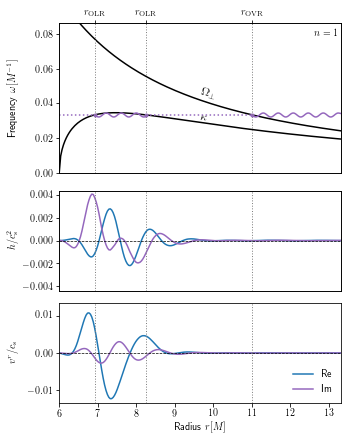

In [141]:
F3_g = func.SampledFunction.zero(radii, valshape=(4,), dtype=complex)

for mode_gg, W_gg in zip(modes_gg, Ws_gg):
    modes_Ggg, forces_Ggg = dsk.nonlinear_coupling(mode_G, W_G, mode_gg, W_gg)
    for mode, force in zip(modes_Ggg, forces_Ggg):
        if mode.n == 1:
            mode3_g = mode
            F3_g += force

for mode_gG, W_gG in zip(modes_gG, Ws_gG):
    modes_ggG, forces_ggG = dsk.nonlinear_coupling(mode_g, W_g, mode_gG, W_gG)
    for mode, force in zip(modes_ggG, forces_ggG):
        if mode.n == 1:
            mode3_g = mode
            F3_g += 2*force

print(mode3_g)
print(mode_g)
print(3*mode_g.omega.imag, mode3_g.omega.imag)

plot_components([mode3_g], [F3_g], radii2)

Scalar products:

In [142]:
U_g = dsk.adjoint_mode(mode_g, W_g)
beta = dsk.scalar_product(mode_g, U_g, F3_g)/dsk.scalar_product(mode_g, U_g, W_g)
print('beta =', beta)

beta = (-4.6668849840761986e-05-0.0006310148000071815j)


After imposing 

In [143]:
F3_g1 = (-beta)*W_g + F3_g
W3_g = dsk

[-4.6668849840761986e-05, -0.0006310148000071815] [0.00748121 0.6143469 ]
[-4.67013200e-05 -6.33998643e-04] [8.56550374e-07 2.14800303e-06]
    fjac: array([[-0.14804562, -0.98898053],
       [ 0.98898053, -0.14804562]])
     fun: array([8.56550374e-07, 2.14800303e-06])
 message: 'The solution converged.'
    nfev: 24
     qtf: array([-2.25114171e-06,  5.29109208e-07])
       r: array([-1.89736278e+08,  3.81096542e+06, -3.13494230e+06])
  status: 1
 success: True
       x: array([-4.67013200e-05, -6.33998643e-04])


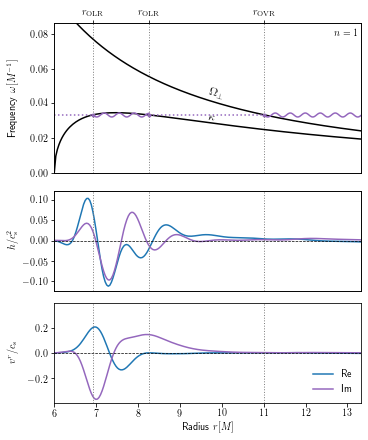

In [144]:
def fitness(X):
    F3_g1 = (-(X[0] + 1j*X[1]))*W_g + F3_g 
    W3_g = dsk.find_response(mode3_g, F3_g1, bc1, bc2, rmax, radii)
    res = dsk.scalar_product(mode3_g, U_g, W3_g)
    return np.array([res.real, res.imag]) 

X0 = [beta.real, beta.imag]
sol = optimize.root(fitness, X0, method='hybr', options={'xtol': 1e-9})    
beta2 = sol.x[0] + 1j*sol.x[1]

print(X0, fitness(X0))
print(sol.x, fitness(sol.x))
print(sol)

F3_g2 = (-beta2)*W_g + F3_g
W3_g2 = dsk.find_response(mode3_g, F3_g2, bc1, bc2, rmax, radii)
plot_components([mode3_g], [W3_g2], radii2)


SampledFunction(rmin=6.0000000001, rmax=13.329898968436378, n=50, valshape=(4,), dtype=complex128)
Resonances: [[[], [6.925781003488102, 7.616611872829325]], [[], []]]


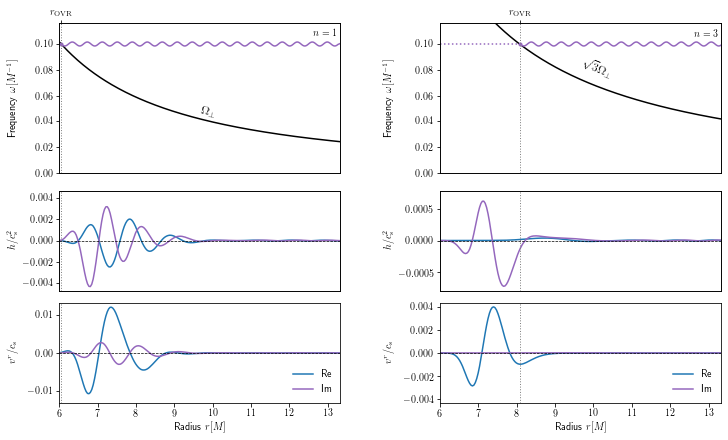

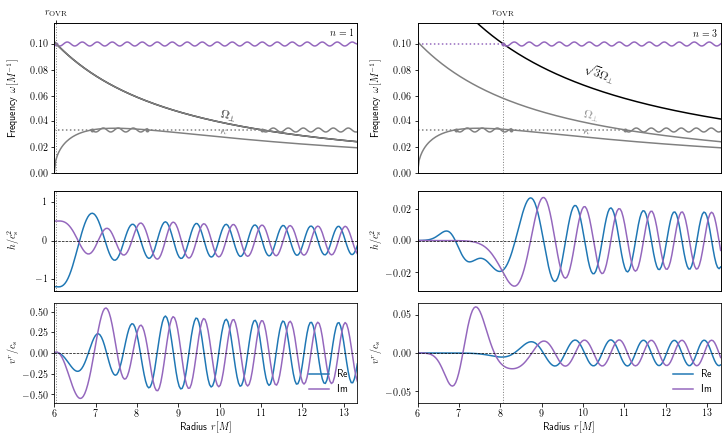

In [98]:
forces_ggg = 2*[func.SampledFunction.zero(radii, valshape=(4,), dtype=complex)]
modes_ggg = [dsk.ModeParam(disk, 0,0,0), dsk.ModeParam(disk,0,0,0)]
components = [1, 3]

print(forces_ggg[1])

for mode, W in zip(modes_gg, Ws_gg):
    modes, forces = dsk.nonlinear_coupling(mode, W, mode_g, W_g)
    for resp_param, F in zip(modes, forces):
        for i, c in enumerate(components):
            if c == resp_param.n:
                forces_ggg[i] += F
                modes_ggg[i] = resp_param

plot_components(modes_ggg, forces_ggg, radii2, freqlim=(0, 3.5*mode_g.omega.real))

Ws_ggg = []
for mode, force in zip(modes_ggg, forces_ggg):
    Ws_ggg.append(dsk.find_response(mode, force, bc1, bc2, rmax, radii))

print('Resonances:', [[dsk.radial_resonances(mode_g, mode1, mode2) for mode1 in modes_gg] for mode2 in modes_ggg])
    
    
plot_components(modes_ggg, Ws_ggg, radii2, bckg=(mode_g, 10), rlabs=len(modes_ggg)*[10.], 
                freqlim=(0, 3.5*mode_g.omega.real))
plt.savefig('ggg-response.pdf', bbox_inches='tight')

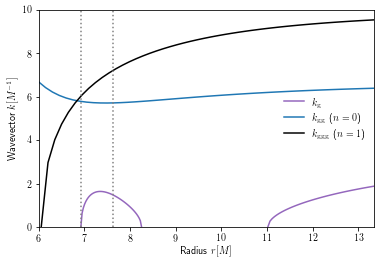

In [145]:
fig, ax = plt.subplots(1)
figs.plot_radial_resonances(ax, mode_g, modes_gg[1], modes_ggg[0], radii2, colors=[mycolor, myrecolor, 'black'], 
                            labels=[r'$k_\mathrm{g}$', r'$k_\mathrm{gg}$ ($n=0$)', r'$k_\mathrm{ggg}$ ($n=1$)'])
ax.legend();